### Grouping for users and predicting the users characteristics by text of the debates

In [1]:
from sklearn import metrics
from scipy.sparse import hstack
from sklearn.metrics import f1_score
from sklearn.preprocessing import LabelEncoder, StandardScaler
from collections import defaultdict
from sklearn.metrics import roc_auc_score
import nltk
from nltk.tokenize import word_tokenize
from nltk import pos_tag
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.preprocessing import LabelEncoder, StandardScaler
from collections import defaultdict
from nltk.corpus import wordnet as wn
from nltk.corpus import wordnet as wn
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn import model_selection, svm 
from sklearn.metrics import accuracy_score
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import random
from sklearn.multioutput import MultiOutputClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error
import warnings
warnings.filterwarnings("ignore")

In [2]:
text=pd.read_csv("non_tokenized.csv")

In [3]:
text.head()

,Unnamed: 0,text,user,side,category,title,url,ideology,party,gender,ethnicity,religion,win_ratio
0,0,Some context on the resolution. Normally I wou...,Mikal,Pro,Miscellaneous,Covenys recent behavior would be a net detrime...,Mikal,Right,Independent,Male,White,Non Believer,0.9684
1,1,We can dismiss most everything in his last rou...,Mikal,Pro,Miscellaneous,Covenys recent behavior would be a net detrime...,Mikal,Right,Independent,Male,White,Non Believer,0.9684
2,2,On to rebuttals1) IntroI'm not sure what he is...,Mikal,Pro,Miscellaneous,Covenys recent behavior would be a net detrime...,Mikal,Right,Independent,Male,White,Non Believer,0.9684
3,3,This is a debate challenge to Cassie on a foru...,Mikal,Con,Politics,Islam is a civilized religion,Mikal,Right,Independent,Male,White,Non Believer,0.9684
4,4,Resending this to Zaro as this was intended fo...,Mikal,Con,Politics,Islam is a civilized religion,Mikal,Right,Independent,Male,White,Non Believer,0.9684


In [67]:
per_users=text[["text","user","ideology","party","gender","ethnicity","religion"]]

In [68]:
per_users.dropna(inplace=True)
per_users=per_users.groupby(["user","ideology","party","gender","ethnicity","religion"],as_index=False)["text"].apply(lambda x: ' '.join(x))


In [69]:
per_users

,user,ideology,party,gender,ethnicity,religion,text
0,0905845,Other,Republican Party,Female,White,Christian,"alright, let's go!\n\r\nyou can go first!"
1,091915,Other,Independent,Female,White,Christian,"Hello, I want to start off with the fact that ..."
2,10438,Other,Independent,Female,White,Christian,"Pageants are performances, in every meaning of..."
3,105060,Other,Other,Male,White,Non Believer,"I sincerely believe it is possible.I, personal..."
4,11BangBangEnvyme,Right,Democratic Party,Male,White,Christian,Obama is the best choice for president. Mitt R...
...,...,...,...,...,...,...,...
3961,zneuser93,Center,Democratic Party,Male,White,Christian,My band:\r\n1:MC: Tupac http://en.wikipedia.or...
3962,zobothehobo,Left,Democratic Party,Female,Middle Eastern,Non Believer,I don't believe texting in class is THAT bad. ...
3963,zoetwinn,Left,Democratic Party,Female,White,Non Believer,First round is acceptance. Preferably my oppon...
3964,zorasbrown,Center,Democratic Party,Male,Asian,Christian,dear con . thers no sound without a listener ....


In [70]:
#per_users=per_users.sample(n=1000)

In [71]:
#per_users=per_users.reset_index()

In [72]:
# Step - a : Remove blank rows if any.
per_users['text'].dropna(inplace=True)
# Step - b : Change all the text to lower case. This is required as python interprets 'dog' and 'DOG' differently
per_users['text_final'] = [entry.lower() for entry in per_users['text']]
# Step - c : Tokenization : In this each entry in the corpus will be broken into set of words
per_users['text_final']= [word_tokenize(entry) for entry in per_users['text_final']]
# Step - d : Remove Stop words, Non-Numeric and perfom Word Stemming/Lemmenting.
# WordNetLemmatizer requires Pos tags to understand if the word is noun or verb or adjective etc. By default it is set to Noun
tag_map = defaultdict(lambda : wn.NOUN)
tag_map['J'] = wn.ADJ
tag_map['V'] = wn.VERB
tag_map['R'] = wn.ADV
for index,entry in enumerate(per_users['text_final']):
    # Declaring Empty List to store the words that follow the rules for this step
    Final_words = []
    # Initializing WordNetLemmatizer()
    word_Lemmatized = WordNetLemmatizer()
    # pos_tag function below will provide the 'tag' i.e if the word is Noun(N) or Verb(V) or something else.
    for word, tag in pos_tag(entry):
        # Below condition is to check for Stop words and consider only alphabets
        if word not in stopwords.words('english') and word.isalpha():
            word_Final = word_Lemmatized.lemmatize(word,tag_map[tag[0]])
            Final_words.append(word_Final)
    # The final processed set of words for each iteration will be stored in 'title_final'
    per_users.loc[index,'text_final'] = str(Final_words)

Dataset has target variables with high imbalanced classes!! We have to solve this 

In [73]:
random.seed(500)

In [74]:
#dividing in train (70% of the dataset) and test set (30% of the dataset)
Train_X, Test_X, Train_Y, Test_Y = model_selection.train_test_split(per_users['text_final'],per_users[['gender','religion','ethnicity','ideology']],test_size=0.3)

In [75]:
Encoder = LabelEncoder()

#word vectorization
Tfidf_vect = TfidfVectorizer(max_features=5000)
Tfidf_vect.fit(per_users["text_final"])
Train_X_Tfidf = Tfidf_vect.transform(Train_X)
Test_X_Tfidf = Tfidf_vect.transform(Test_X)



In [76]:
#Label encode the target variable — 
#This is done to transform Categorical data of string type in the data set 
#into numerical values which the model can understand.

#gender
Train_Y_gender = Encoder.fit_transform(Train_Y['gender'])
Test_Y_gender = Encoder.fit_transform(Test_Y['gender'])

#religion
Train_Y_rel = Encoder.fit_transform(Train_Y['religion'])
Test_Y_rel = Encoder.fit_transform(Test_Y['religion'])

#ethnicity
Train_Y_ethn = Encoder.fit_transform(Train_Y['ethnicity'])
Test_Y_ethn = Encoder.fit_transform(Test_Y['ethnicity'])

#ideology
Train_Y_id = Encoder.fit_transform(Train_Y['ideology'])
Test_Y_id = Encoder.fit_transform(Test_Y['ideology'])

#stacking into a vector
y_train=np.stack((Train_Y_gender,Train_Y_rel,Train_Y_ethn,Train_Y_id),axis=1)
y_test=np.stack((Test_Y_gender,Test_Y_rel,Test_Y_ethn,Test_Y_id),axis=1)

In [77]:
#using we can use the argument class_weight='balanced'  
#to penalize mistakes on the minority class by an amount proportional to how under-represented it is.
SVM = svm.SVC(C=1.0, kernel='linear',class_weight='balanced', gamma='auto',decision_function_shape='ovo',probability=True)
# Create the Multioutput Classifier
mor = MultiOutputClassifier(SVM)
# Train the regressor
mor.fit(Train_X_Tfidf, y_train)
# Generate predictions for testing data
y_pred = mor.predict(Test_X_Tfidf)



In [78]:
print("SVM Metrics for Gender")
print(f"The F1 score is {f1_score(y_test[:,0], y_pred[:,0], average='weighted')}")

SVM Metrics for Gender
The F1 score is 0.7631421022728189


In [79]:
#i-th row and j-th column entry indicates the number of samples with true label being i-th class and predicted label being j-th class.
metrics.confusion_matrix(y_test[:,0], y_pred[:,0])

array([[131,   1,  99],
       [  6,   0,   4],
       [184,   1, 764]], dtype=int64)

In [80]:
print("SVM Metrics for Religion")
print(f"The F1 score is {f1_score(y_test[:,1], y_pred[:,1], average='weighted')}")

SVM Metrics for Religion
The F1 score is 0.46328247541885736


In [81]:
metrics.confusion_matrix(y_test[:,1], y_pred[:,1])

array([[261,   4, 133,  96],
       [ 10,   4,   2,   3],
       [132,   1, 229,  92],
       [ 81,   2,  85,  55]], dtype=int64)

In [82]:
print("SVM Metrics for Ethnicity")
print(f"The F1 score is {f1_score(y_test[:,2], y_pred[:,2], average='weighted')}")

SVM Metrics for Ethnicity
The F1 score is 0.46271566814414217


In [83]:
# What about AUROC?
metrics.confusion_matrix(y_test[:,2], y_pred[:,2])

array([[ 29,   6,   1,   7,   0,   0,  18,   0,  27],
       [ 10,  11,   1,   6,   1,   0,  16,   1,  28],
       [  3,   0,   0,   0,   0,   0,   0,   0,   5],
       [  8,   6,   0,   6,   0,   0,  16,   0,  33],
       [  5,   1,   0,   0,   0,   0,   2,   0,   5],
       [  3,   1,   0,   1,   0,   0,   3,   0,   6],
       [ 12,   2,   0,   6,   0,   1,   5,   0,  25],
       [  4,   0,   0,   0,   0,   0,   1,   0,   4],
       [114,  65,   2,  71,   1,   3, 181,   3, 424]], dtype=int64)

In [84]:
# Use accuracy_score function to get the accuracy
print("SVM Accuracy Score Ideology")
print(f"The F1 score is {f1_score(y_test[:,3], y_pred[:,3], average='weighted')}")

SVM Accuracy Score Ideology
The F1 score is 0.3624201470741777


In [85]:
metrics.confusion_matrix(y_test[:,3], y_pred[:,3])

array([[ 60,  29,  51,  47],
       [ 44,  36,  49,  40],
       [ 60,  39,  94,  61],
       [134, 100, 126, 220]], dtype=int64)

In [94]:
# Cross Validation
from sklearn.model_selection import StratifiedKFold

folds=range(1,11)
SVM = svm.SVC(C=1.0, kernel='linear',class_weight='balanced', gamma='auto',decision_function_shape='ovo',probability=True)

X=per_users['text_final']
y=per_users['gender']
skf = StratifiedKFold(n_splits=10)

f1_ge=[]
for train_index, test_index in skf.split(X, y):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    #Encoding
    Encoder = LabelEncoder()

    #word vectorization
    Tfidf_vect = TfidfVectorizer(max_features=5000)
    Tfidf_vect.fit(per_users["text_final"])
    Train_X_Tfidf = Tfidf_vect.transform(X_train)
    Test_X_Tfidf = Tfidf_vect.transform(X_test)

    #gender
    y_train = Encoder.fit_transform(y_train)
    y_test = Encoder.fit_transform(y_test)

    
    clf = SVM.fit(Train_X_Tfidf, y_train)
    y_pred = clf.predict(Test_X_Tfidf)
    f1_ge.append(f1_score(y_test,y_pred, average="weighted"))
    

    
    
f1_re=[]    
y=per_users['religion']
skf = StratifiedKFold(n_splits=10)

for train_index, test_index in skf.split(X, y):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    #Encoding
    Encoder = LabelEncoder()

    #word vectorization
    Tfidf_vect = TfidfVectorizer(max_features=5000)
    Tfidf_vect.fit(per_users["text_final"])
    Train_X_Tfidf = Tfidf_vect.transform(X_train)
    Test_X_Tfidf = Tfidf_vect.transform(X_test)

    #gender
    y_train = Encoder.fit_transform(y_train)
    y_test = Encoder.fit_transform(y_test)

    
    clf = SVM.fit(Train_X_Tfidf, y_train)
    y_pred = clf.predict(Test_X_Tfidf)

    f1_re.append(f1_score(y_test,y_pred, average="weighted"))    

f1_et=[]    
y=per_users['ethnicity']
skf = StratifiedKFold(n_splits=10)

for train_index, test_index in skf.split(X, y):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    #Encoding
    Encoder = LabelEncoder()

    #word vectorization
    Tfidf_vect = TfidfVectorizer(max_features=5000)
    Tfidf_vect.fit(per_users["text_final"])
    Train_X_Tfidf = Tfidf_vect.transform(X_train)
    Test_X_Tfidf = Tfidf_vect.transform(X_test)

    #gender
    y_train = Encoder.fit_transform(y_train)
    y_test = Encoder.fit_transform(y_test)

    
    clf = SVM.fit(Train_X_Tfidf, y_train)
    y_pred = clf.predict(Test_X_Tfidf)

    f1_et.append(f1_score(y_test,y_pred, average="weighted")) 
    
    
f1_id=[]    
y=per_users['ideology']
skf = StratifiedKFold(n_splits=10)

for train_index, test_index in skf.split(X, y):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    #Encoding
    Encoder = LabelEncoder()

    #word vectorization
    Tfidf_vect = TfidfVectorizer(max_features=5000)
    Tfidf_vect.fit(per_users["text_final"])
    Train_X_Tfidf = Tfidf_vect.transform(X_train)
    Test_X_Tfidf = Tfidf_vect.transform(X_test)

    #gender
    y_train = Encoder.fit_transform(y_train)
    y_test = Encoder.fit_transform(y_test)

    
    clf = SVM.fit(Train_X_Tfidf, y_train)
    y_pred = clf.predict(Test_X_Tfidf)

    f1_id.append(f1_score(y_test,y_pred, average="weighted"))     



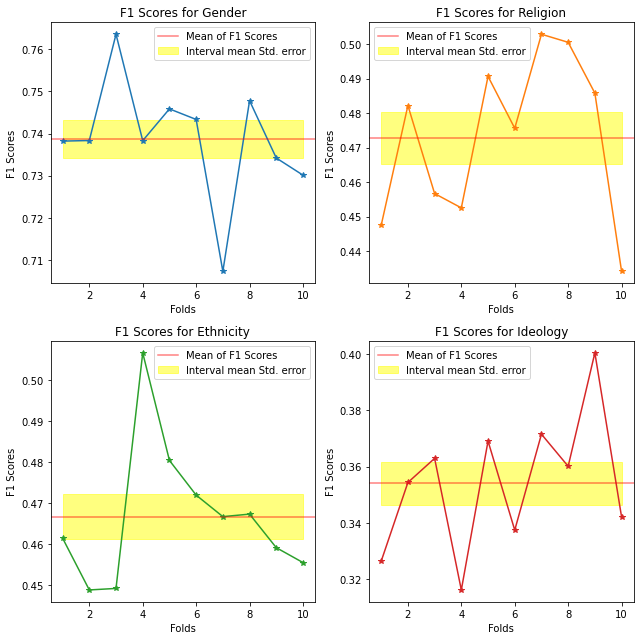

In [144]:
#Plotting values    
sem_ge = np.std(f1_ge, ddof=1) / np.sqrt(np.size(f1_ge))
sem_re = np.std(f1_re, ddof=1) / np.sqrt(np.size(f1_re))
sem_et = np.std(f1_et, ddof=1) / np.sqrt(np.size(f1_et))
sem_id = np.std(f1_id, ddof=1) / np.sqrt(np.size(f1_id))



fig, axs = plt.subplots(2, 2,figsize=(9,9))
axs[0, 0].plot(folds, f1_ge, marker='*')
axs[0, 0].axhline(np.mean(f1_ge), color='red',alpha=0.5, label='Mean of F1 Scores')
axs[0, 0].fill_between(folds,np.mean(f1_ge)+sem_ge,np.mean(f1_ge)-sem_ge,color='yellow',alpha=0.5, label="Interval mean Std. error")
axs[0, 0].set_title('F1 Scores for Gender')
axs[0, 1].plot(folds, f1_re, 'tab:orange', marker='*')
axs[0, 1].axhline(np.mean(f1_re), color='red',alpha=0.5, label='Mean of F1 Scores')
axs[0, 1].fill_between(folds,np.mean(f1_re)+sem_re,np.mean(f1_re)-sem_re,color='yellow',alpha=0.5, label="Interval mean Std. error")
axs[0, 1].set_title('F1 Scores for Religion')
axs[1, 0].plot(folds, f1_et, 'tab:green', marker='*')
axs[1, 0].axhline(np.mean(f1_et), color='red',alpha=0.5, label='Mean of F1 Scores')
axs[1, 0].fill_between(folds,np.mean(f1_et)+sem_et,np.mean(f1_et)-sem_et,color='yellow',alpha=0.5, label="Interval mean Std. error")
axs[1, 0].set_title('F1 Scores for Ethnicity')
axs[1, 1].plot(folds, f1_id, 'tab:red', marker='*')
axs[1, 1].axhline(np.mean(f1_id), color='red',alpha=0.5, label='Mean of F1 Scores')
axs[1, 1].fill_between(folds,np.mean(f1_id)+sem_id,np.mean(f1_id)-sem_id,color='yellow',alpha=0.5, label="Interval mean Std. error")
axs[1, 1].set_title('F1 Scores for Ideology')

for ax in axs.flat:
    ax.set(xlabel='Folds', ylabel='F1 Scores')
    
axs[0,0].legend(loc='upper right')    
axs[0,1].legend(loc='upper left')    
axs[1,0].legend(loc='upper right')    
axs[1,1].legend(loc='upper left')    


fig.tight_layout()

### Dividing Dataset into two dataset, one with text length higher than the median, the other with text length lower than the median

In [145]:
def length(x):
    l=0
    for i in x:
        for j in i:
            l+=len(j)
            
    return l

per_users["text_length"]=per_users["text"].apply(length)

In [146]:
val_med=int(np.median(per_users["text_length"]))

#dividing the dataset into two model
#Model 1: text_length>val_med
#Model 1: text_length>val_med

per_users_high=per_users[per_users["text_length"]>val_med].reset_index()
per_users_low=per_users[per_users["text_length"]<val_med].reset_index()


In [147]:
#dividing in train (70% of the dataset) and test set (30% of the dataset)
Train_X, Test_X, Train_Y, Test_Y = model_selection.train_test_split(per_users_high['text_final'],per_users_high[['gender','religion','ethnicity','ideology']],test_size=0.3)

In [148]:
Encoder = LabelEncoder()

#word vectorization
Tfidf_vect = TfidfVectorizer(max_features=5000)
Tfidf_vect.fit(per_users_high["text_final"])
Train_X_Tfidf = Tfidf_vect.transform(Train_X)
Test_X_Tfidf = Tfidf_vect.transform(Test_X)



In [149]:
#Label encode the target variable — 
#This is done to transform Categorical data of string type in the data set 
#into numerical values which the model can understand.

#gender
Train_Y_gender = Encoder.fit_transform(Train_Y['gender'])
Test_Y_gender = Encoder.fit_transform(Test_Y['gender'])

#religion
Train_Y_rel = Encoder.fit_transform(Train_Y['religion'])
Test_Y_rel = Encoder.fit_transform(Test_Y['religion'])

#ethnicity
Train_Y_ethn = Encoder.fit_transform(Train_Y['ethnicity'])
Test_Y_ethn = Encoder.fit_transform(Test_Y['ethnicity'])

#ideology
Train_Y_id = Encoder.fit_transform(Train_Y['ideology'])
Test_Y_id = Encoder.fit_transform(Test_Y['ideology'])

#stacking into a vector
y_train=np.stack((Train_Y_gender,Train_Y_rel,Train_Y_ethn,Train_Y_id),axis=1)
y_test_high=np.stack((Test_Y_gender,Test_Y_rel,Test_Y_ethn,Test_Y_id),axis=1)

In [150]:
#using we can use the argument class_weight='balanced'  
#to penalize mistakes on the minority class by an amount proportional to how under-represented it is.
SVM = svm.SVC(C=1.0, kernel='linear',class_weight='balanced',gamma='auto', decision_function_shape='ovo',probability=True)
# Create the Multioutput Classifier
mor = MultiOutputClassifier(SVM)
# Train the regressor
mor.fit(Train_X_Tfidf, y_train)
# Generate predictions for testing data
y_pred_high = mor.predict(Test_X_Tfidf)



In [151]:
print("SVM Metrics for Gender")
print(f"The F1 score is {f1_score(y_test_high[:,0], y_pred_high[:,0], average='weighted')}")

SVM Metrics for Gender
The F1 score is 0.8201706912273105


In [152]:
print("SVM Metrics for Religion")
print(f"The F1 score is {f1_score(y_test_high[:,1], y_pred_high[:,1], average='weighted')}")

SVM Metrics for Religion
The F1 score is 0.4740563411361208


In [153]:
metrics.confusion_matrix(y_test_high[:,1], y_pred_high[:,1])

array([[119,   2,  70,  45],
       [  5,   4,   2,   3],
       [ 58,   1, 143,  42],
       [ 36,   1,  48,  16]], dtype=int64)

In [154]:
print("SVM Metrics for Ethnicity")
print(f"The F1 score is {f1_score(y_test_high[:,2], y_pred_high[:,2], average='weighted')}")

SVM Metrics for Ethnicity
The F1 score is 0.5178844388764523


In [155]:
# Use accuracy_score function to get the accuracy
print("SVM Accuracy Score Ideology")
print(f"The F1 score is {f1_score(y_test_high[:,3], y_pred_high[:,3], average='weighted')}")

SVM Accuracy Score Ideology
The F1 score is 0.32366051977055527


In [156]:
# Cross Validation
from sklearn.model_selection import StratifiedKFold

folds=range(1,11)
SVM = svm.SVC(C=1.0, kernel='linear',class_weight='balanced', gamma='auto',decision_function_shape='ovo',probability=True)

X=per_users_high['text_final']
y=per_users_high['gender']
skf = StratifiedKFold(n_splits=10)

f1_ge_high=[]
for train_index, test_index in skf.split(X, y):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    #Encoding
    Encoder = LabelEncoder()

    #word vectorization
    Tfidf_vect = TfidfVectorizer(max_features=5000)
    Tfidf_vect.fit(per_users["text_final"])
    Train_X_Tfidf = Tfidf_vect.transform(X_train)
    Test_X_Tfidf = Tfidf_vect.transform(X_test)

    #gender
    y_train = Encoder.fit_transform(y_train)
    y_test = Encoder.fit_transform(y_test)

    
    clf = SVM.fit(Train_X_Tfidf, y_train)
    y_pred = clf.predict(Test_X_Tfidf)
    f1_ge_high.append(f1_score(y_test,y_pred, average="weighted"))
    

    
    
f1_re_high=[]    
y=per_users_high['religion']
skf = StratifiedKFold(n_splits=10)

for train_index, test_index in skf.split(X, y):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    #Encoding
    Encoder = LabelEncoder()

    #word vectorization
    Tfidf_vect = TfidfVectorizer(max_features=5000)
    Tfidf_vect.fit(per_users["text_final"])
    Train_X_Tfidf = Tfidf_vect.transform(X_train)
    Test_X_Tfidf = Tfidf_vect.transform(X_test)

    #gender
    y_train = Encoder.fit_transform(y_train)
    y_test = Encoder.fit_transform(y_test)

    
    clf = SVM.fit(Train_X_Tfidf, y_train)
    y_pred = clf.predict(Test_X_Tfidf)

    f1_re_high.append(f1_score(y_test,y_pred, average="weighted"))    

f1_et_high=[]    
y=per_users_high['ethnicity']
skf = StratifiedKFold(n_splits=10)

for train_index, test_index in skf.split(X, y):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    #Encoding
    Encoder = LabelEncoder()

    #word vectorization
    Tfidf_vect = TfidfVectorizer(max_features=5000)
    Tfidf_vect.fit(per_users["text_final"])
    Train_X_Tfidf = Tfidf_vect.transform(X_train)
    Test_X_Tfidf = Tfidf_vect.transform(X_test)

    #gender
    y_train = Encoder.fit_transform(y_train)
    y_test = Encoder.fit_transform(y_test)

    
    clf = SVM.fit(Train_X_Tfidf, y_train)
    y_pred = clf.predict(Test_X_Tfidf)

    f1_et_high.append(f1_score(y_test,y_pred, average="weighted")) 
    
    
f1_id_high=[]    
y=per_users_high['ideology']
skf = StratifiedKFold(n_splits=10)

for train_index, test_index in skf.split(X, y):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    #Encoding
    Encoder = LabelEncoder()

    #word vectorization
    Tfidf_vect = TfidfVectorizer(max_features=5000)
    Tfidf_vect.fit(per_users["text_final"])
    Train_X_Tfidf = Tfidf_vect.transform(X_train)
    Test_X_Tfidf = Tfidf_vect.transform(X_test)

    #gender
    y_train = Encoder.fit_transform(y_train)
    y_test = Encoder.fit_transform(y_test)

    
    clf = SVM.fit(Train_X_Tfidf, y_train)
    y_pred = clf.predict(Test_X_Tfidf)

    f1_id_high.append(f1_score(y_test,y_pred, average="weighted"))     



In [157]:
#dividing in train (70% of the dataset) and test set (30% of the dataset)
Train_X, Test_X, Train_Y, Test_Y = model_selection.train_test_split(per_users_low['text_final'],per_users_low[['gender','religion','ethnicity','ideology']],test_size=0.3)

In [158]:
Encoder = LabelEncoder()

#word vectorization
Tfidf_vect = TfidfVectorizer(max_features=5000)
Tfidf_vect.fit(per_users_low["text_final"])
Train_X_Tfidf = Tfidf_vect.transform(Train_X)
Test_X_Tfidf = Tfidf_vect.transform(Test_X)



In [159]:
#Label encode the target variable — 
#This is done to transform Categorical data of string type in the data set 
#into numerical values which the model can understand.

#gender
Train_Y_gender = Encoder.fit_transform(Train_Y['gender'])
Test_Y_gender = Encoder.fit_transform(Test_Y['gender'])

#religion
Train_Y_rel = Encoder.fit_transform(Train_Y['religion'])
Test_Y_rel = Encoder.fit_transform(Test_Y['religion'])

#ethnicity
Train_Y_ethn = Encoder.fit_transform(Train_Y['ethnicity'])
Test_Y_ethn = Encoder.fit_transform(Test_Y['ethnicity'])

#ideology
Train_Y_id = Encoder.fit_transform(Train_Y['ideology'])
Test_Y_id = Encoder.fit_transform(Test_Y['ideology'])

#stacking into a vector
y_train=np.stack((Train_Y_gender,Train_Y_rel,Train_Y_ethn,Train_Y_id),axis=1)
y_test_low=np.stack((Test_Y_gender,Test_Y_rel,Test_Y_ethn,Test_Y_id),axis=1)

In [160]:
#using we can use the argument class_weight='balanced'  
#to penalize mistakes on the minority class by an amount proportional to how under-represented it is.
SVM = svm.SVC(C=1.0, kernel='linear',class_weight='balanced',gamma='auto',probability=True)
# Create the Multioutput Classifier
mor = MultiOutputClassifier(SVM)
# Train the regressor
mor.fit(Train_X_Tfidf, y_train)
# Generate predictions for testing data
y_pred_low = mor.predict(Test_X_Tfidf)



In [161]:
print("SVM Metrics for Gender")
print(f"The F1 score is {f1_score(y_test_low[:,0], y_pred_low[:,0], average='weighted')}")

SVM Metrics for Gender
The F1 score is 0.6937933038579925


In [162]:
print("SVM Metrics for Religion")
print(f"The F1 score is {f1_score(y_test_low[:,1], y_pred_low[:,1], average='weighted')}")

SVM Metrics for Religion
The F1 score is 0.431320276644926


In [163]:
print("SVM Metrics for Ethnicity")
print(f"The F1 score is {f1_score(y_test_low[:,2], y_pred_low[:,2], average='weighted')}")

SVM Metrics for Ethnicity
The F1 score is 0.5420330279867851


In [164]:
print("SVM Accuracy Score Ideology")
print(f"The F1 score is {f1_score(y_test_low[:,3], y_pred_low[:,3], average='weighted')}")

SVM Accuracy Score Ideology
The F1 score is 0.35435398193253365


In [165]:
# Cross Validation
from sklearn.model_selection import StratifiedKFold

folds=range(1,11)
SVM = svm.SVC(C=1.0, kernel='linear',class_weight='balanced', gamma='auto',decision_function_shape='ovo',probability=True)

X=per_users_low['text_final']
y=per_users_low['gender']
skf = StratifiedKFold(n_splits=10)

f1_ge_low=[]
for train_index, test_index in skf.split(X, y):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    #Encoding
    Encoder = LabelEncoder()

    #word vectorization
    Tfidf_vect = TfidfVectorizer(max_features=5000)
    Tfidf_vect.fit(per_users["text_final"])
    Train_X_Tfidf = Tfidf_vect.transform(X_train)
    Test_X_Tfidf = Tfidf_vect.transform(X_test)

    #gender
    y_train = Encoder.fit_transform(y_train)
    y_test = Encoder.fit_transform(y_test)

    
    clf = SVM.fit(Train_X_Tfidf, y_train)
    y_pred = clf.predict(Test_X_Tfidf)
    f1_ge_low.append(f1_score(y_test,y_pred, average="weighted"))
    

    
    
f1_re_low=[]    
y=per_users_low['religion']
skf = StratifiedKFold(n_splits=10)

for train_index, test_index in skf.split(X, y):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    #Encoding
    Encoder = LabelEncoder()

    #word vectorization
    Tfidf_vect = TfidfVectorizer(max_features=5000)
    Tfidf_vect.fit(per_users["text_final"])
    Train_X_Tfidf = Tfidf_vect.transform(X_train)
    Test_X_Tfidf = Tfidf_vect.transform(X_test)

    #gender
    y_train = Encoder.fit_transform(y_train)
    y_test = Encoder.fit_transform(y_test)

    
    clf = SVM.fit(Train_X_Tfidf, y_train)
    y_pred = clf.predict(Test_X_Tfidf)

    f1_re_low.append(f1_score(y_test,y_pred, average="weighted"))    

f1_et_low=[]    
y=per_users_low['ethnicity']
skf = StratifiedKFold(n_splits=10)

for train_index, test_index in skf.split(X, y):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    #Encoding
    Encoder = LabelEncoder()

    #word vectorization
    Tfidf_vect = TfidfVectorizer(max_features=5000)
    Tfidf_vect.fit(per_users["text_final"])
    Train_X_Tfidf = Tfidf_vect.transform(X_train)
    Test_X_Tfidf = Tfidf_vect.transform(X_test)

    #gender
    y_train = Encoder.fit_transform(y_train)
    y_test = Encoder.fit_transform(y_test)

    
    clf = SVM.fit(Train_X_Tfidf, y_train)
    y_pred = clf.predict(Test_X_Tfidf)

    f1_et_low.append(f1_score(y_test,y_pred, average="weighted")) 
    
    
f1_id_low=[]    
y=per_users_low['ideology']
skf = StratifiedKFold(n_splits=10)

for train_index, test_index in skf.split(X, y):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    #Encoding
    Encoder = LabelEncoder()

    #word vectorization
    Tfidf_vect = TfidfVectorizer(max_features=5000)
    Tfidf_vect.fit(per_users["text_final"])
    Train_X_Tfidf = Tfidf_vect.transform(X_train)
    Test_X_Tfidf = Tfidf_vect.transform(X_test)

    #gender
    y_train = Encoder.fit_transform(y_train)
    y_test = Encoder.fit_transform(y_test)

    
    clf = SVM.fit(Train_X_Tfidf, y_train)
    y_pred = clf.predict(Test_X_Tfidf)

    f1_id_low.append(f1_score(y_test,y_pred, average="weighted"))     



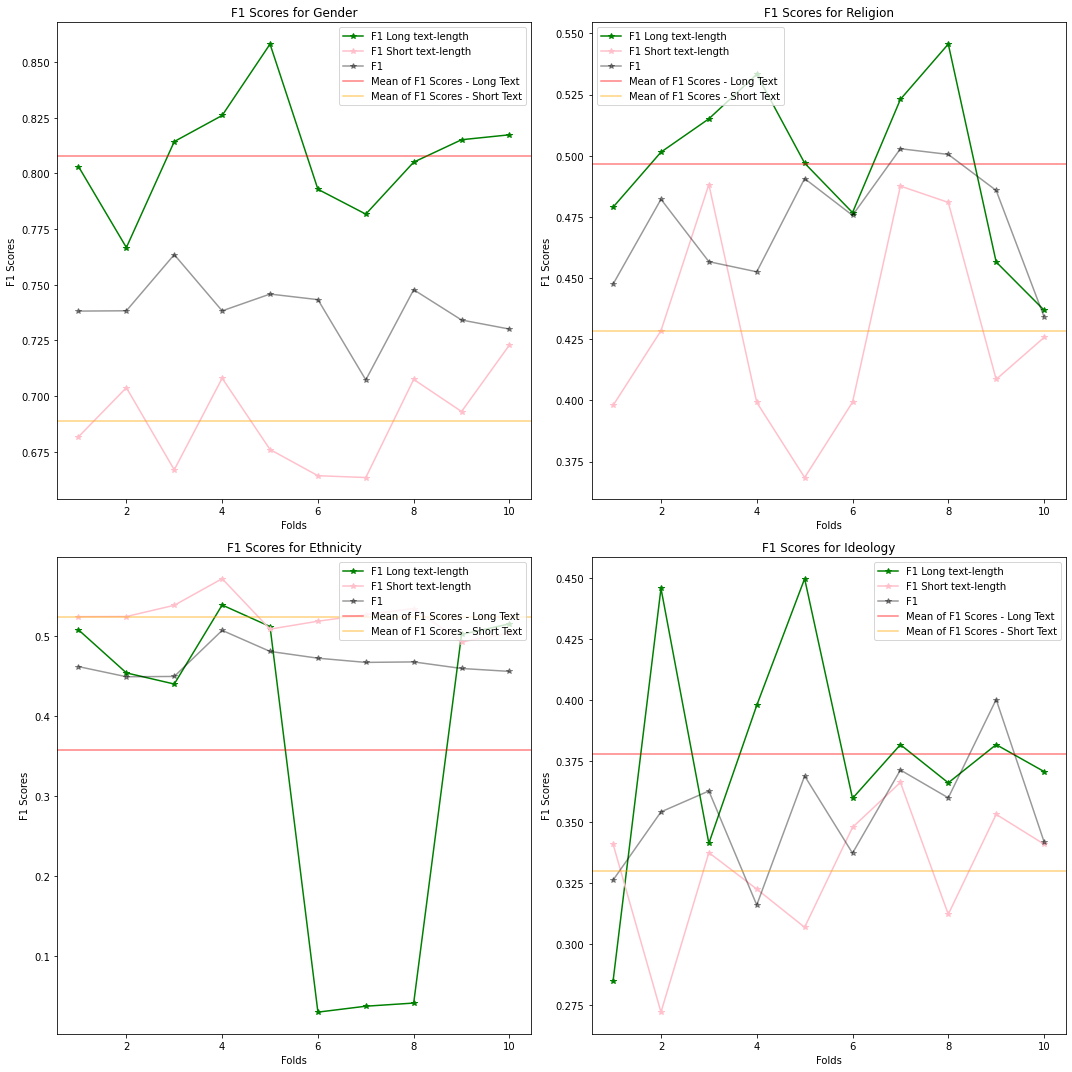

In [173]:
#Plotting values    
fig, axs = plt.subplots(2, 2,figsize=(15,15))
axs[0, 0].plot(folds, f1_ge_high, marker='*', color="green",label="F1 Long text-length")
axs[0, 0].plot(folds, f1_ge_low, marker='*',color='pink', label="F1 Short text-length")
axs[0, 0].plot(folds, f1_ge, marker='*', color="black", label="F1",alpha=0.4)
axs[0, 0].axhline(np.mean(f1_ge_high), color='red',alpha=0.5, label='Mean of F1 Scores - Long Text')
axs[0, 0].axhline(np.mean(f1_ge_low), color='orange',alpha=0.5, label='Mean of F1 Scores - Short Text')
#axs[0, 0].fill_between(folds,np.mean(f1_ge)+sem_ge,np.mean(f1_ge)-sem_ge,color='yellow',alpha=0.5, label="Interval mean Std. error")
axs[0, 0].set_title('F1 Scores for Gender')
axs[0, 1].plot(folds, f1_re_high, marker='*',color="green", label="F1 Long text-length")
axs[0, 1].plot(folds, f1_re_low, marker='*',color='pink', label="F1 Short text-length")
axs[0, 1].plot(folds, f1_re, marker='*', color="black", label="F1",alpha=0.4)
axs[0, 1].axhline(np.mean(f1_re_high), color='red',alpha=0.5, label='Mean of F1 Scores - Long Text')
axs[0, 1].axhline(np.mean(f1_re_low), color='orange',alpha=0.5, label='Mean of F1 Scores - Short Text')
#axs[0, 1].fill_between(folds,np.mean(f1_re)+sem_re,np.mean(f1_re)-sem_re,color='yellow',alpha=0.5, label="Interval mean Std. error")
axs[0, 1].set_title('F1 Scores for Religion')
axs[1, 0].plot(folds, f1_et_high, marker='*',color="green", label="F1 Long text-length")
axs[1, 0].plot(folds, f1_et_low, marker='*',color='pink', label="F1 Short text-length")
axs[1, 0].plot(folds, f1_et, marker='*', color="black", label="F1",alpha=0.4)
axs[1, 0].axhline(np.mean(f1_et_high), color='red',alpha=0.5, label='Mean of F1 Scores - Long Text')
axs[1, 0].axhline(np.mean(f1_et_low), color='orange',alpha=0.5, label='Mean of F1 Scores - Short Text')
#axs[1, 0].fill_between(folds,np.mean(f1_et)+sem_et,np.mean(f1_et)-sem_et,color='yellow',alpha=0.5, label="Interval mean Std. error")
axs[1, 0].set_title('F1 Scores for Ethnicity')
axs[1, 1].plot(folds, f1_id_high, marker='*',color='green', label="F1 Long text-length")
axs[1, 1].plot(folds, f1_id_low, marker='*',color='pink', label="F1 Short text-length")
axs[1, 1].plot(folds, f1_id, marker='*', color="black", label="F1",alpha=0.4)
axs[1, 1].axhline(np.mean(f1_id_high), color='red',alpha=0.5, label='Mean of F1 Scores - Long Text')
axs[1, 1].axhline(np.mean(f1_id_low), color='orange',alpha=0.5, label='Mean of F1 Scores - Short Text')
#axs[1, 1].fill_between(folds,np.mean(f1_id)+sem_id,np.mean(f1_id)-sem_id,color='yellow',alpha=0.5, label="Interval mean Std. error")
axs[1, 1].set_title('F1 Scores for Ideology')

for ax in axs.flat:
    ax.set(xlabel='Folds', ylabel='F1 Scores')
    
axs[0,0].legend(loc='upper right')    
axs[0,1].legend(loc='upper left')    
axs[1,0].legend(loc='upper right')    
axs[1,1].legend(loc='upper right')    


fig.tight_layout()

#### Adding the side and the title to the text columns

In [54]:
text.dropna(inplace=True)

def func(x,y,z):
    x='---'.join(x)
    y='---'.join(y)
    z='---'.join(z)
    return x,y,z

first_gb=text.groupby(["user","title","side","ideology","party","gender","ethnicity","religion"],as_index=False)["text"].apply(lambda x: ' '.join(x))

In [49]:
first_gb.head()

,user,title,side,ideology,party,gender,ethnicity,religion,text
0,0905845,Rap Battle 5 Cheesedingo VS 0905845,Con,Other,Republican Party,Female,White,Christian,"alright, let's go!\n\r\nyou can go first!"
1,091915,does everything revolves around math?,Con,Other,Independent,Female,White,Christian,"Hello, I want to start off with the fact that ..."
2,10438,Pageants are STUPID.,Con,Other,Independent,Female,White,Christian,"Pageants are performances, in every meaning of..."
3,105060,Is it possible to create an actual utopia?,Pro,Other,Other,Male,White,Non Believer,"I sincerely believe it is possible.I, personal..."
4,11BangBangEnvyme,Obama is the best choice for president.,Pro,Right,Democratic Party,Male,White,Christian,Obama is the best choice for president. Mitt R...


In [56]:
second_gb=first_gb.groupby(["user","ideology","party","gender","ethnicity","religion"],as_index=False)[["text","title","side"]].apply(lambda x: func(x.title,x.text,x.side))

In [72]:
second_gb.to_csv("title_text_user.csv")

In [77]:
sample=second_gb[:300]
sample=sample.reset_index()

In [83]:
# Step - a : Remove blank rows if any.
sample['title'].dropna(inplace=True)
# Step - b : Change all the text to lower case. This is required as python interprets 'dog' and 'DOG' differently
sample['title_final'] = [entry.lower() for entry in sample['title']]
# Step - c : Tokenization : In this each entry in the corpus will be broken into set of words
sample['title_final']= [word_tokenize(entry) for entry in sample['title_final']]
# Step - d : Remove Stop words, Non-Numeric and perfom Word Stemming/Lemmenting.
# WordNetLemmatizer requires Pos tags to understand if the word is noun or verb or adjective etc. By default it is set to Noun
tag_map = defaultdict(lambda : wn.NOUN)
tag_map['J'] = wn.ADJ
tag_map['V'] = wn.VERB
tag_map['R'] = wn.ADV
for index,entry in enumerate(sample['title_final']):
    # Declaring Empty List to store the words that follow the rules for this step
    Final_words = []
    # Initializing WordNetLemmatizer()
    word_Lemmatized = WordNetLemmatizer()
    # pos_tag function below will provide the 'tag' i.e if the word is Noun(N) or Verb(V) or something else.
    for word, tag in pos_tag(entry):
        # Below condition is to check for Stop words and consider only alphabets
        if word not in stopwords.words('english') and word.isalpha():
            word_Final = word_Lemmatized.lemmatize(word,tag_map[tag[0]])
            Final_words.append(word_Final)
    # The final processed set of words for each iteration will be stored in 'title_final'
    sample.loc[index,'title_final'] = str(Final_words)

AttributeError: 'tuple' object has no attribute 'lower'

In [81]:
[print(entry) for entry in sample['text']]

('text',)


[None]

In [75]:
# Step - a : Remove blank rows if any.
sample['text'].dropna(inplace=True)
# Step - b : Change all the text to lower case. This is required as python interprets 'dog' and 'DOG' differently
sample['text_final'] = [entry.lower() for entry in sample['text']]
# Step - c : Tokenization : In this each entry in the corpus will be broken into set of words
sample['text_final']= [word_tokenize(entry) for entry in sample['text_final']]
# Step - d : Remove Stop words, Non-Numeric and perfom Word Stemming/Lemmenting.
# WordNetLemmatizer requires Pos tags to understand if the word is noun or verb or adjective etc. By default it is set to Noun
tag_map = defaultdict(lambda : wn.NOUN)
tag_map['J'] = wn.ADJ
tag_map['V'] = wn.VERB
tag_map['R'] = wn.ADV
for index,entry in enumerate(sample['text_final']):
    # Declaring Empty List to store the words that follow the rules for this step
    Final_words = []
    # Initializing WordNetLemmatizer()
    word_Lemmatized = WordNetLemmatizer()
    # pos_tag function below will provide the 'tag' i.e if the word is Noun(N) or Verb(V) or something else.
    for word, tag in pos_tag(entry):
        # Below condition is to check for Stop words and consider only alphabets
        if word not in stopwords.words('english') and word.isalpha():
            word_Final = word_Lemmatized.lemmatize(word,tag_map[tag[0]])
            Final_words.append(word_Final)
    # The final processed set of words for each iteration will be stored in 'title_final'
    sample.loc[index,'text_final'] = str(Final_words)

AttributeError: 'tuple' object has no attribute 'lower'

In [76]:
#dividing in train (70% of the dataset) and test set (30% of the dataset)
Train_X, Test_X, Train_Y, Test_Y = model_selection.train_test_split(sample[["title_final",'text_final',"side"]],sample[['gender','religion','ethnicity','ideology']],test_size=0.3)

#Encoding
Encoder = LabelEncoder()

#word vectorization
Tfidf_vect = TfidfVectorizer(max_features=5000)
Tfidf_vect.fit(sample["title_final"])
Train_X_Tfidf_title = Tfidf_vect.transform(Train_X["title_final"])
Test_X_Tfidf_title = Tfidf_vect.transform(Test_X["title_final"])
Tfidf_vect = TfidfVectorizer(max_features=5000)
Tfidf_vect.fit(sample["text_final"])
Train_X_Tfidf_text = Tfidf_vect.transform(Train_X["text_final"])
Test_X_Tfidf_text = Tfidf_vect.transform(Test_X["text_final"])

#encoding the side
Train_X_1_pos = Encoder.fit_transform(Train_X['side'])
Test_X_1_pos = Encoder.fit_transform(Test_X['side'])

#stacking everything together
mat_train= hstack([Train_X_Tfidf_title,Train_X_Tfidf_text])
X_train_tfidf = hstack([mat_train, Train_X_1_pos.reshape(-1, 1)])
mat_test= hstack([Test_X_Tfidf_title,Test_X_Tfidf_text])
X_test_tfidf = hstack([mat_test, Test_X_1_pos.reshape(-1, 1)])

#Label encode the target variable — 
#This is done to transform Categorical data of string type in the data set 
#into numerical values which the model can understand.

#gender
Train_Y_gender = Encoder.fit_transform(Train_Y['gender'])
Test_Y_gender = Encoder.fit_transform(Test_Y['gender'])

#religion
Train_Y_rel = Encoder.fit_transform(Train_Y['religion'])
Test_Y_rel = Encoder.fit_transform(Test_Y['religion'])

#ethnicity
Train_Y_ethn = Encoder.fit_transform(Train_Y['ethnicity'])
Test_Y_ethn = Encoder.fit_transform(Test_Y['ethnicity'])

#ideology
Train_Y_id = Encoder.fit_transform(Train_Y['ideology'])
Test_Y_id = Encoder.fit_transform(Test_Y['ideology'])

#stacking into a vector
y_train=np.stack((Train_Y_gender,Train_Y_rel,Train_Y_ethn,Train_Y_id),axis=1)
y_test=np.stack((Test_Y_gender,Test_Y_rel,Test_Y_ethn,Test_Y_id),axis=1)

KeyError: "['title_final' 'text_final'] not in index"

In [64]:
#using we can use the argument class_weight='balanced'  
#to penalize mistakes on the minority class by an amount proportional to how under-represented it is.
SVM = svm.SVC(C=1.0, kernel='linear',class_weight='balanced',gamma='auto',probability=True)
# Create the Multioutput Classifier
mor = MultiOutputClassifier(SVM)
# Train the regressor
mor.fit(X_train_tfidf, y_train)
# Generate predictions for testing data
y_pred = mor.predict(X_test_tfidf)



In [65]:
print("SVM Metrics for Gender")
print(f"The F1 score is {f1_score(y_test[:,0], y_pred[:,0], average='weighted')}")

SVM Metrics for Gender
The F1 score is 0.7575757575757576


In [66]:
print("SVM Metrics for Religion")
print(f"The F1 score is {f1_score(y_test[:,1], y_pred[:,1], average='weighted')}")

SVM Metrics for Religion
The F1 score is 0.3047619047619048


In [67]:
print("SVM Metrics for Ethnicity")
print(f"The F1 score is {f1_score(y_test[:,2], y_pred[:,2], average='weighted')}")

SVM Metrics for Ethnicity
The F1 score is 0.21960784313725493


In [68]:
print("SVM Accuracy Score Ideology")
print(f"The F1 score is {f1_score(y_test[:,3], y_pred[:,3], average='weighted')}")

SVM Accuracy Score Ideology
The F1 score is 0.12873563218390802
